# Process :
    - DATA PREPROCESS 
    - SELECT MODELS 
    - FEATURE ENGINEERING 
       - Add new features : AVG price/kilometer/powerPS
    - PREDICTION ENSEMBLE 

#  Model :  
    - * Linear regression for every car group (barnd)
    - Modeling for different sub group data set  
# =========================================================

In [1]:
# Load basics library 

import pandas as pd, numpy as np
%matplotlib inline
%pylab inline
import seaborn  as sns 
import pylab as pl
import matplotlib.pyplot as plt

Populating the interactive namespace from numpy and matplotlib


# * 1 ) Data Preprocess 

In [2]:
# load car csv 

df = pd.read_csv('/Users/yennanliu/Desktop/used-cars-database/autos.csv' ,encoding = "ISO-8859-1" )

In [3]:
df = df.drop(['nrOfPictures','postalCode','abtest'], axis=1)

- Drop columns :  nrOfPictures, postalCode, abtest 
   - nrOfPictures  are all 0 
   - postalCode is not related to car price apparently
   - abtest has no description

In [4]:
df = df[(df.price < 150000) & (df.price > 100) ]

- Drop extreme big / small / unusual price data points

In [5]:
df = df[(df.yearOfRegistration > 1900) & (df.yearOfRegistration <= 2016) ]

- Remove no sense yearOfRegistration data points , > 1900 for possible earlist register time, and <= 2016 based on lastSeen column

In [6]:
df = df[(df.powerPS > 50) & (df.powerPS < 1000) ]

- Cleaning up the powerPS

In [7]:
# transform string to timestamp 

df.dateCrawled = pd.to_datetime(df.dateCrawled)
df.dateCreated = pd.to_datetime(df.dateCreated)
df.lastSeen = pd.to_datetime(df.lastSeen)

In [8]:
# create new feature : "time_online" by differences in days among lastseen and datesreated

df['time_online'] = (df.lastSeen - df.dateCreated).apply(lambda x: int(x.days))

- time_online :  how long such car object exist on ebay website

In [9]:
#max(df.dateCrawled)

In [10]:
# CHECK features correlation

corr = df.corr()
corr.loc[:,'price'].abs().sort_values(ascending=False)[1:]

powerPS                0.577120
kilometer              0.448864
yearOfRegistration     0.391513
time_online            0.127522
monthOfRegistration    0.042002
Name: price, dtype: float64

In [11]:
#plot_correlation_map(df)

In [12]:
selected_feature = ['price',
                    'powerPS',
                    'kilometer',
                    'yearOfRegistration',
                    'time_online']
                    #'monthOfRegistration']

In [13]:
selected_feature

['price', 'powerPS', 'kilometer', 'yearOfRegistration', 'time_online']

## 1-1) Visualization

In [14]:
###

##  After data preprocess,  get prepared data sample :  


In [15]:
print ('car sample counts :' , len(df))
print ('seleceted feature :' , selected_feature)

car sample counts : 301479
seleceted feature : ['price', 'powerPS', 'kilometer', 'yearOfRegistration', 'time_online']


# * 2)  SELECT MODELS
    - Linear 
    - SVR
    - Decision tree
    - Random forest

###  Before first run model, we need to split data set into TRAIN and TEST group for evaluate prediction accuracy ahead really given test 

In [16]:
#  help function 

from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score, mean_absolute_error


def sample_split(data):
    #data =  data[selected_feature]
    relevent_cols = list(data)
    autos=data.values.astype(float)             
    Y = autos[:,0]
    X = autos[:,1:]
    test_size = .3
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, random_state = 3)
    return X_train, X_test, y_train, y_test


def reg_analysis(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    prediction = model.predict(X_test)
    #Calculate Variance score
    Variance_score = explained_variance_score(y_test, prediction)
    print ('Variance score : %.2f' %Variance_score)
    #Mean Absolute Error
    MAE = mean_absolute_error(y_test, prediction)
    print ('Mean Absolute Error : %.2f' %MAE)
    #Root Mean Squared Error
    RMSE = mean_squared_error(y_test, prediction)**0.5
    print ('Mean Squared Error : %.2f' %RMSE)
    #R² score, the coefficient of determination
    r2s = r2_score(y_test, prediction)
    print ('R2  score : %.2f' %r2s)
    return model
    

def plot_correlation_map( df ):
    corr = df.corr()
    _ , ax = plt.subplots( figsize =( 12 , 10 ) )
    cmap = sns.diverging_palette( 220 , 10 , as_cmap = True )
    _ = sns.heatmap(
        corr, 
        cmap = cmap,
        square=True, 
        cbar_kws={ 'shrink' : .9 }, 
        ax=ax, 
        annot = True, 
        annot_kws = { 'fontsize' : 12 }
    )

In [18]:
df.head()

,dateCrawled,name,seller,offerType,price,vehicleType,yearOfRegistration,gearbox,powerPS,model,kilometer,monthOfRegistration,fuelType,brand,notRepairedDamage,dateCreated,lastSeen,time_online
1,2016-03-24 10:58:45,A5_Sportback_2.7_Tdi,privat,Angebot,18300,coupe,2011,manuell,190,NaN,125000,5,diesel,audi,ja,2016-03-24,2016-04-07 01:46:50,14
2,2016-03-14 12:52:21,"Jeep_Grand_Cherokee_""Overland""",privat,Angebot,9800,suv,2004,automatik,163,grand,125000,8,diesel,jeep,NaN,2016-03-14,2016-04-05 12:47:46,22
3,2016-03-17 16:54:04,GOLF_4_1_4__3TÜRER,privat,Angebot,1500,kleinwagen,2001,manuell,75,golf,150000,6,benzin,volkswagen,nein,2016-03-17,2016-03-17 17:40:17,0
4,2016-03-31 17:25:20,Skoda_Fabia_1.4_TDI_PD_Classic,privat,Angebot,3600,kleinwagen,2008,manuell,69,fabia,90000,7,diesel,skoda,nein,2016-03-31,2016-04-06 10:17:21,6
5,2016-04-04 17:36:23,BMW_316i___e36_Limousine___Bastlerfahrzeug__Ex...,privat,Angebot,650,limousine,1995,manuell,102,3er,150000,10,benzin,bmw,ja,2016-04-04,2016-04-06 19:17:07,2


In [19]:
#list(df.brand)

df.groupby('brand').count().reset_index().sort('price',ascending=False)

//anaconda/envs/g_dash/lib/python3.4/site-packages/ipykernel_launcher.py:3: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  This is separate from the ipykernel package so we can avoid doing imports until


,brand,dateCrawled,name,seller,offerType,price,vehicleType,yearOfRegistration,gearbox,powerPS,model,kilometer,monthOfRegistration,fuelType,notRepairedDamage,dateCreated,lastSeen,time_online
38,volkswagen,62399,62399,62399,62399,62399,59506,62399,61374,62399,60513,62399,62399,59225,52894,62399,62399,62399
2,bmw,35374,35374,35374,35374,35374,34571,35374,35025,35374,34253,35374,35374,33859,31004,35374,35374,35374
24,opel,31069,31069,31069,31069,31069,29689,31069,30463,31069,30034,31069,31069,29039,26050,31069,31069,31069
20,mercedes_benz,30358,30358,30358,30358,30358,29723,30358,29962,30358,29693,30358,30358,29306,26929,30358,30358,30358
1,audi,28888,28888,28888,28888,28888,28129,28888,28622,28888,28134,28888,28888,27718,25228,28888,28888,28888
10,ford,20147,20147,20147,20147,20147,19342,20147,19804,20147,19629,20147,20147,18988,17117,20147,20147,20147
27,renault,13601,13601,13601,13601,13601,13040,13601,13345,13601,13212,13601,13601,12768,11412,13601,13601,13601
25,peugeot,9139,9139,9139,9139,9139,8853,9139,8985,9139,8640,9139,9139,8653,7920,9139,9139,9139
9,fiat,7229,7229,7229,7229,7229,6919,7229,7065,7229,6988,7229,7229,6831,6130,7229,7229,7229
30,seat,5303,5303,5303,5303,5303,5085,5303,5233,5303,5192,5303,5303,5056,4672,5303,5303,5303


In [60]:
# http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html

from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(list(set(df[:1000]['brand'])))
#list(set(df[:1000]['brand']))

LabelEncoder()

In [67]:
brand_color = le.transform(list(set(df[:1000]['brand'])))

In [70]:
brand_color

array([ 9,  1, 17, 22,  5, 13, 20, 32, 27,  4, 12, 28, 31,  7, 15, 16, 24,
        0, 23, 35, 25, 19,  3, 30, 18, 33, 36, 29,  2, 21, 11, 14, 26, 34,
       10,  8,  6])

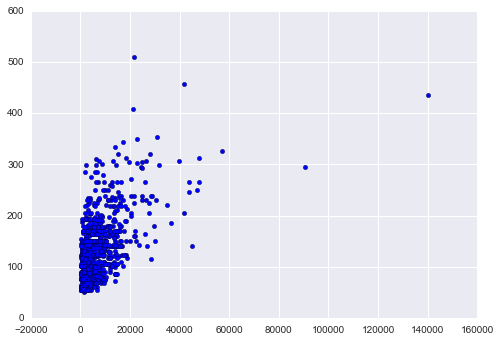

In [80]:
df__ = df[:1000]


for brand in list(set(df[:1000]['brand'])):
    #print (brand)
    x = df__[df__.brand == brand]['price']
    y = df__[df__.brand == brand]['powerPS']
    plt.scatter(x, y)
plt.show()

In [37]:
df_volk = df[df.brand=='volkswagen']
df_bmw = df[df.brand=='bmw']
df_opel = df[df.brand=='opel']
df_benz = df[df.brand=='mercedes_benz']

In [46]:
X_train, X_test, y_train, y_test = sample_split(df_volk[selected_feature])

In [48]:
# Linear model 

from sklearn import linear_model

model = linear_model.LinearRegression()
print ('Linear Regression')
reg_analysis(model,X_train, X_test, y_train, y_test)

Linear Regression
Variance score : 0.63
Mean Absolute Error : 2427.72
Mean Squared Error : 3879.57
R2  score : 0.63


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

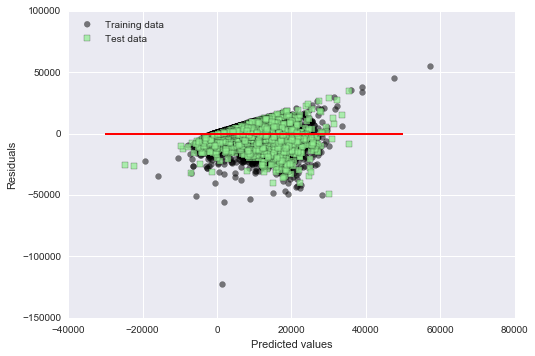

In [49]:
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)


plt.scatter(y_train_pred,
           y_train_pred - y_train,
           c='black',
           marker='o',
           s=35,
           alpha=0.5,
           label ='Training data')

plt.scatter(y_test_pred,
           y_test_pred - y_test,
           c='lightgreen',
           marker='s',
           s=35,
           alpha=0.7,
           label ='Test data')

plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.legend(loc='upper left')
plt.hlines(y=0,xmin=-30000,xmax=50000,lw=2,color='red')
plt.show()

In [28]:
# only grab 2953 minor dataset for fast run SVR 

df_sample = df.sample(frac=0.1, replace=True).reset_index()
df_sample

X_train_, X_test_, y_train_, y_test_ = sample_split(df_sample[selected_feature])

In [25]:
# SVR

from sklearn.svm import SVR
# run linear SVR first ( kernel = linear)

model = SVR(kernel='rbf', C=1e3, gamma=0.1)
print ('SVR')
#reg_analysis(model,X_train, X_test, y_train, y_test)

SVR


In [30]:
# SVR

from sklearn.svm import SVR
# run linear SVR first ( kernel = linear)

model = SVR(kernel='rbf', C=1e3, gamma=0.1)
print ('SVR')
#reg_analysis(model,X_train, X_test, y_train, y_test)

SVR


In [41]:
# linear SVR

#from sklearn.svm import SVR
# run linear SVR first ( kernel = linear)

from sklearn.svm import LinearSVR

model = LinearSVR()
print ('SVR')
reg_analysis(model,X_train, X_test, y_train, y_test)

SVR
Variance score : 0.39
Mean Absolute Error : 11864.32
Mean Squared Error : 13609.61
R2  score : -0.94


LinearSVR(C=1.0, dual=True, epsilon=0.0, fit_intercept=True,
     intercept_scaling=1.0, loss='epsilon_insensitive', max_iter=1000,
     random_state=None, tol=0.0001, verbose=0)